# # Customer Transaction Insights Dashboard

This notebook analyzes a simulated e-commerce dataset to generate actionable business insights.
The analysis covers customer segmentation, payment behavior, transaction frequency, and churn.
The goal is to demonstrate how data analysts can extract meaningful patterns and present them visually.

We will explore:

Who the customers are (new vs returning)
How they behave (frequency, payments, churn)
What patterns emerge from their transactions
The end goal is to turn raw data into business insights that decision-makers care about.


In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Setup
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

# Load the dataset
df = pd.read_csv("shopping_trends.csv")
df.head()


,customer_id,age,gender,item_purchased,category,purchase_amount_(usd),location,size,color,season,review_rating,subscription_status,payment_method,shipping_type,discount_applied,promo_code_used,previous_purchases,preferred_payment_method,frequency_of_purchases,purchase_date
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Credit Card,Express,Yes,Yes,14,Venmo,Fortnightly,2023-04-13
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Bank Transfer,Express,Yes,Yes,2,Cash,Fortnightly,2023-12-15
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Cash,Free Shipping,Yes,Yes,23,Credit Card,Weekly,2023-09-28
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,PayPal,Next Day Air,Yes,Yes,49,PayPal,Weekly,2023-04-17
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Cash,Free Shipping,Yes,Yes,31,PayPal,Annually,2023-03-13


## First Look at the Dataset

This dataset comes from a shopping platform, but we will treat it as Customer’s transaction logs for learning purposes.
Let's take a peek at the structure and understand what we're working with.

In [11]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               3900 non-null   int64  
 1   age                       3900 non-null   int64  
 2   gender                    3900 non-null   object 
 3   item_purchased            3900 non-null   object 
 4   category                  3900 non-null   object 
 5   purchase_amount_(usd)     3900 non-null   int64  
 6   location                  3900 non-null   object 
 7   size                      3900 non-null   object 
 8   color                     3900 non-null   object 
 9   season                    3900 non-null   object 
 10  review_rating             3900 non-null   float64
 11  subscription_status       3900 non-null   object 
 12  payment_method            3900 non-null   object 
 13  shipping_type             3900 non-null   object 
 14  discount

##  Data Cleaning & Prep

Before jumping into analysis, it's important to clean the data.
We rename columns for easier reference and check for missing or messy data.

In [12]:
# Rename columns for cleaner reference
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Convert subscription status to binary: 1 = Returning, 0 = New
df['is_returning_customer'] = df['subscription_status'].map({'Yes': 1, 'No': 0})

# Let’s confirm
df[['subscription_status', 'is_returning_customer']].head()


,subscription_status,is_returning_customer
0,Yes,1
1,Yes,1
2,Yes,1
3,Yes,1
4,Yes,1


## Summary KPIs

Let's start with some key performance indicators (KPIs) to get a quick overview of the dataset.


In [ ]:
# Summary KPIs
total_customers = df['is_returning_customer'].nunique()
total_transactions = df.shape[0]
avg_purchases = df['previous_purchases'].mean()

print(f"Customer Types Present: {total_customers}")
print(f"Total Transactions: {total_transactions}")
print(f"Average Previous Purchases: {avg_purchases:.2f}")


Total Customers: 2
Total Transactions: 3900
Average Previous Purchases: 25.35


##  Customer Segmentation: New vs Returning

Let’s start by understanding our customer base.  
Are most users one-time visitors or do they keep coming back?


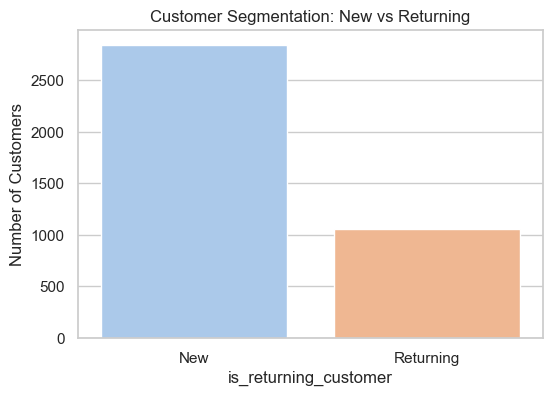

In [14]:
import matplotlib.pyplot as plt

segment_counts = df['is_returning_customer'].value_counts().rename({0: 'New', 1: 'Returning'})

plt.figure(figsize=(6,4))
sns.barplot(x=segment_counts.index, y=segment_counts.values, hue=segment_counts.index, palette='pastel', legend=False)
plt.title("Customer Segmentation: New vs Returning")
plt.ylabel("Number of Customers")
plt.show()


## Monthly Transaction Trends

This chart shows how transaction volume changes over months, indicating seasonality or growth.


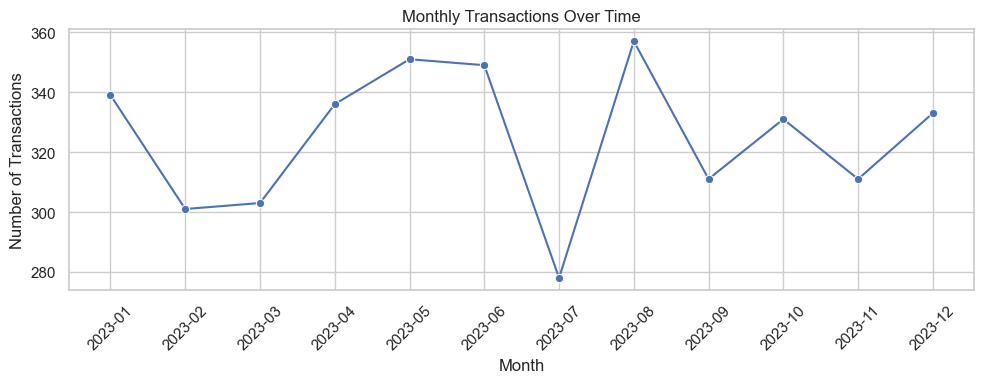

In [15]:
# Convert purchase_date to datetime if not already done
df['purchase_date'] = pd.to_datetime(df['purchase_date'], errors='coerce')

# Extract month for trend analysis
df['month'] = df['purchase_date'].dt.to_period('M').astype(str)

monthly_trend = df['month'].value_counts().sort_index()

plt.figure(figsize=(10,4))
sns.lineplot(x=monthly_trend.index, y=monthly_trend.values, marker='o')
plt.title("Monthly Transactions Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##  Transaction Frequency

Let's explore how often users shop.
We'll use previous_purchases as a proxy for their historical transaction count.

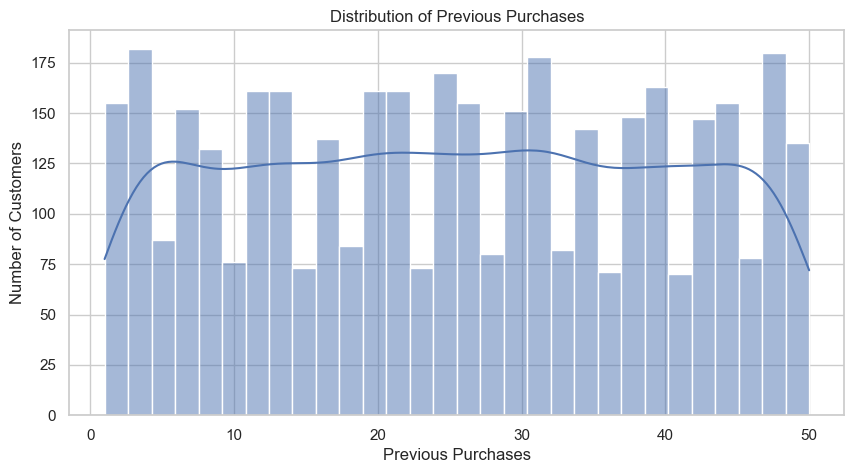

In [16]:
plt.figure(figsize=(10,5))
sns.histplot(df['previous_purchases'], bins=30, kde=True)
plt.title("Distribution of Previous Purchases")
plt.xlabel("Previous Purchases")
plt.ylabel("Number of Customers")
plt.show()


##  Payment Method Preference

Which payment methods are most commonly used?
This gives us insight into what transaction modes Customer users (or shoppers) lean towards.

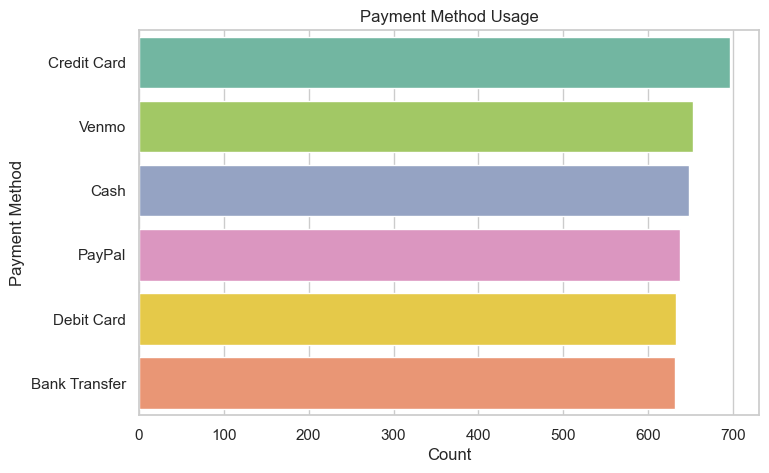

In [17]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, y='payment_method', order=df['payment_method'].value_counts().index, hue='payment_method', palette="Set2", legend=False)
plt.title("Payment Method Usage")
plt.xlabel("Count")
plt.ylabel("Payment Method")
plt.show()


##  Customer Churn Analysis

Let's try identifying churned users — a simple proxy could be users with only one previous purchase.
We'll also check whether these churned users were new or returning when they transacted.


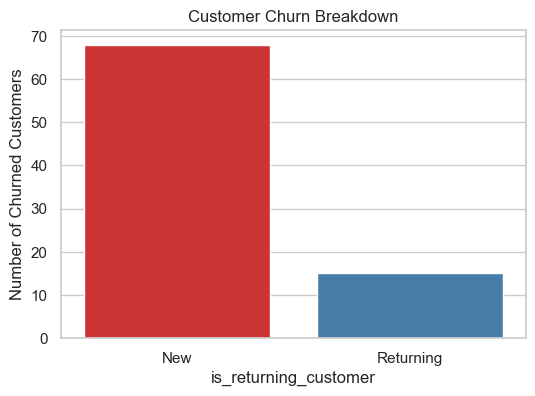

In [18]:
churned = df[df['previous_purchases'] <= 1]
churn_segment = churned['is_returning_customer'].value_counts().rename({0: 'New', 1: 'Returning'})

plt.figure(figsize=(6,4))
sns.barplot(x=churn_segment.index, y=churn_segment.values, hue=churn_segment.index, palette='Set1', legend=False)
plt.title("Customer Churn Breakdown")
plt.ylabel("Number of Churned Customers")
plt.show()


## Interactive Filter: Explore Purchase Frequency

Use the dropdown below to filter and view customers by their purchase frequency.


In [19]:
import ipywidgets as widgets
from IPython.display import display

def filter_by_frequency(freq):
    filtered = df[df['frequency_of_purchases'] == freq]
    display(filtered.head())

freq_dropdown = widgets.Dropdown(
    options=df['frequency_of_purchases'].unique().tolist(),
    description='Frequency:'
)

widgets.interact(filter_by_frequency, freq=freq_dropdown)


interactive(children=(Dropdown(description='Frequency:', options=('Fortnightly', 'Weekly', 'Annually', 'Quarte…

<function __main__.filter_by_frequency(freq)>

##  Purchase Frequency Patterns

The column frequency_of_purchases shows how often users transact (weekly, monthly, etc).
Let's explore it to identify high-frequency users.


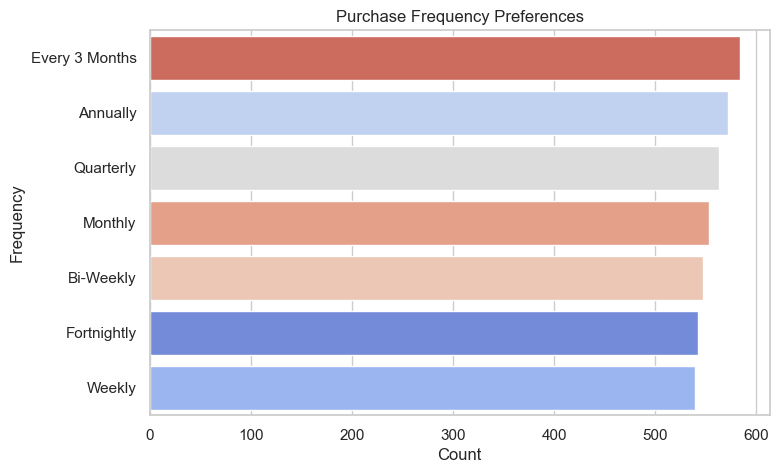

In [20]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, y='frequency_of_purchases', order=df['frequency_of_purchases'].value_counts().index, hue='frequency_of_purchases', palette='coolwarm', legend=False)
plt.title("Purchase Frequency Preferences")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()


##  Final Takeaways

- Most users in this data are **returning customers**, showing signs of loyalty.
- **Credit Card** and **Customer** are among the top payment modes.
- Users with only **1 previous purchase** (likely churned) are mostly **new customers**.
- Purchase frequency varies a lot — we see weekly and monthly shoppers being dominant.

This kind of analysis helps businesses make retention strategies, optimize payment flow, and even personalize offers.  



##  Time-Based Trend Analysis

We analyze monthly and weekly transaction patterns to understand temporal trends.


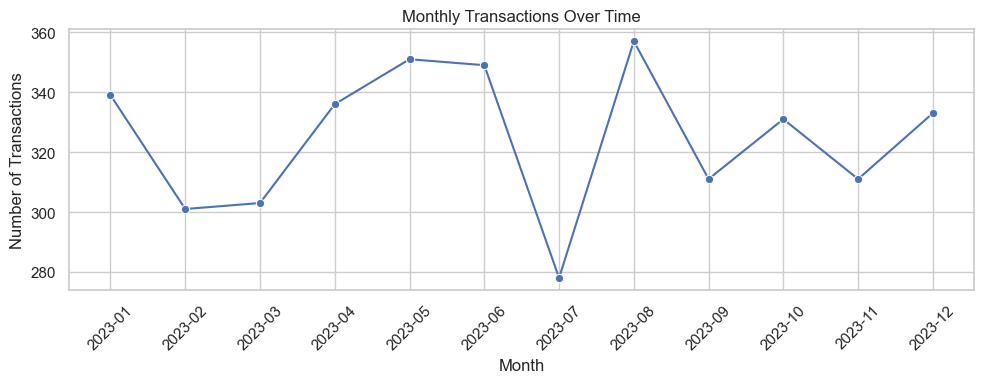

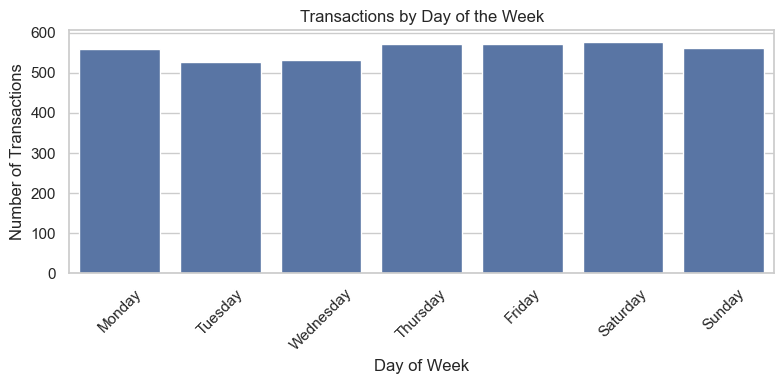

In [21]:

# Time-Based Trends 

# Convert purchase_date to datetime (if not already done)
df['purchase_date'] = pd.to_datetime(df['purchase_date'], errors='coerce')

# Extract time components
df['month'] = df['purchase_date'].dt.to_period('M').astype(str)
df['day_of_week'] = df['purchase_date'].dt.day_name()

# Plot: Monthly Transaction Volume
monthly_trend = df['month'].value_counts().sort_index()
plt.figure(figsize=(10,4))
sns.lineplot(x=monthly_trend.index, y=monthly_trend.values, marker='o')
plt.title("Monthly Transactions Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot: Weekly Transaction Volume
weekly_trend = df['day_of_week'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.figure(figsize=(8,4))
sns.barplot(x=weekly_trend.index, y=weekly_trend.values)
plt.title("Transactions by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
